<a href="https://colab.research.google.com/github/DayenaJeong/FS_neuron/blob/main/FS_conversion_poisson_sigmoid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [3]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()

        if num_params == 4:
            h = torch.tensor([0.9813, -1.9998, -0.6859, 0.0726])
            d = torch.tensor([0.4719, 0.8930, -0.2312, -0.1692])
            T = torch.tensor([-1.2178, -0.0103, 0.9895, 0.9898])
        elif num_params == 8:
            h = torch.tensor([6.8620, 3.8446, 3.4882, 1.5610, 1.1893, 1.4751, -2.6189, 0.1495])
            d = torch.tensor([0.0891, 0.6711, 0.0253, 0.1613, -0.0060, -0.0086, 0.9554, -0.7933])
            T = torch.tensor([9.2329, 0.0567, 2.0161, -1.2216, 0.5962, -0.3178, -2.6367, -1.0322])
        elif num_params == 12:
            h = torch.tensor([1.9139, 1.2510, 2.0618, 0.7526, 1.5032, 0.3668, 1.9875, 1.1889, 0.5554, 0.4489, 1.1767, 0.1623])
            d = torch.tensor([0.4217, 0.2337, 0.1932, 0.0021, 0.0887, 0.0465, 0.0138, 1.2080, -0.0026, 0.1974, 0.0001, 0.0001])
            T = torch.tensor([0.0443, -0.9573, -1.5970, 2.4553, -2.7807, -3.4746, -2.0787, 1.7883, 0.7193, 3.4051, 0.2201, -0.0492])
        elif num_params == 16:
            h = torch.tensor([2.5733, 1.3121, 0.8950, 1.0941, 1.5366, 0.5694, 1.4563, 0.9944, 1.0961, -1.9481, 1.2481, 0.3490, 0.4921, 0.7793, 2.7194, 1.0211])
            d = torch.tensor([0.5183, 0.2210, 0.0476, 0.0298, 0.0310, 0.0015, 0.0008, 0.0011, 0.0026, 0.3293, -0.2537, 1.2654, 0.8791, 0.0033, 0.0023, 0.0710])
            T = torch.tensor([0.1467, -1.1673, -2.9088, -4.0010, -2.0569, 0.0914, 0.6653, 0.5048, 0.2919, -4.0346, -3.0172, 1.8976, 1.8881, 0.3116, 0.0206, -2.8496])

        self.h = nn.Parameter(h + torch.poisson(torch.full(h.size(), 0.1)).float())
        self.d = nn.Parameter(d + torch.poisson(torch.full(d.size(), 0.1)).float())
        self.T = nn.Parameter(T + torch.poisson(torch.full(T.size(), 0.1)).float())

    def forward(self, x):
        v = x.clone()

        # Initialize temporary output for FS spike neural network
        temp_out = torch.zeros_like(v)

        # Implement FS spike neural network
        for t in range(len(self.T)):
            #v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            v_scaled = v - self.T[t]
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        return temp_out

# Sigmoid

K=4

Epoch 1/20000, Loss: 0.005719464272260666
Epoch 1001/20000, Loss: 0.005719678942114115
Epoch 2001/20000, Loss: 0.005719620268791914
Epoch 3001/20000, Loss: 0.005719687324017286
Epoch 4001/20000, Loss: 0.005719529930502176
Epoch 5001/20000, Loss: 0.005719679407775402
Epoch 6001/20000, Loss: 0.005719613749533892
Epoch 7001/20000, Loss: 0.005719470791518688
Epoch 8001/20000, Loss: 0.005719693377614021
Epoch 9001/20000, Loss: 0.005719680339097977
Epoch 10001/20000, Loss: 0.0057196058332920074
Epoch 11001/20000, Loss: 0.005719752050936222
Epoch 12001/20000, Loss: 0.005719561595469713
Epoch 13001/20000, Loss: 0.00571953970938921
Epoch 14001/20000, Loss: 0.005719686392694712
Epoch 15001/20000, Loss: 0.005719608627259731
Epoch 16001/20000, Loss: 0.0057196482084691525
Epoch 17001/20000, Loss: 0.005719831679016352
Epoch 18001/20000, Loss: 0.005719680804759264
Epoch 19001/20000, Loss: 0.005719468928873539
Loss values: [0.005719464272260666, 0.005719679407775402, 0.005719606298953295, 0.0057196789

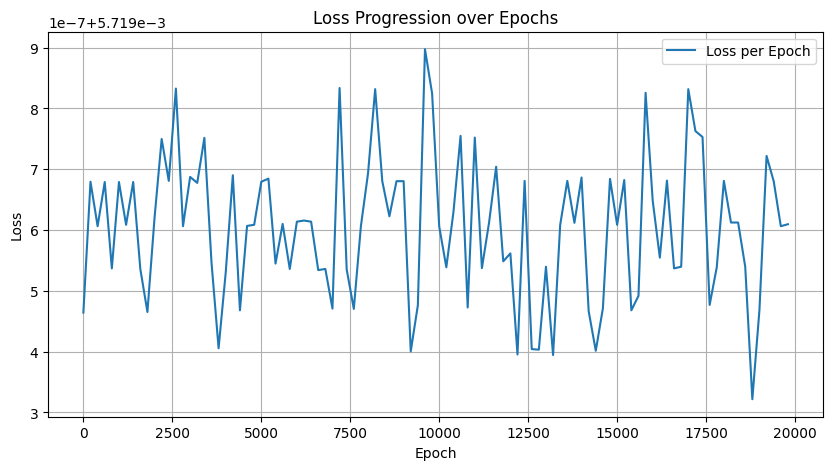

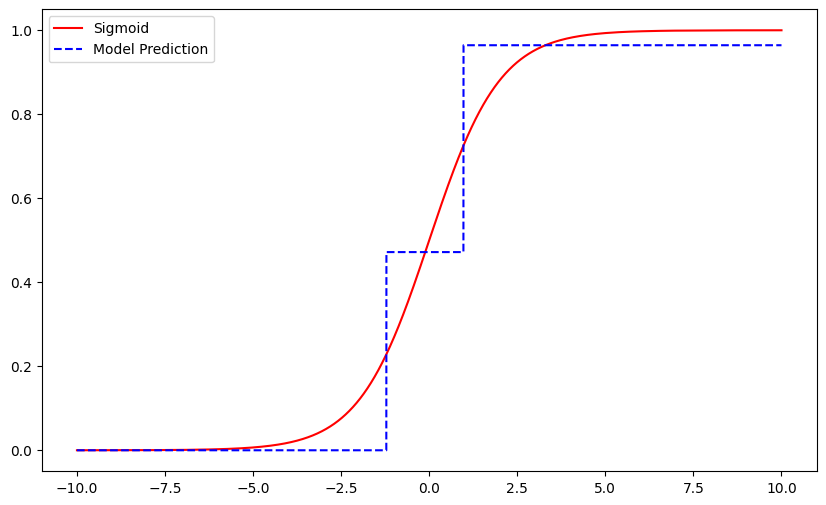

In [4]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-10, 10, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = sigmoid(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = sigmoid(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Sigmoid', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
# plt.xlabel('Input x')
# plt.ylabel('Output y')
plt.legend()

plt.show()

K=8

Epoch 1/20000, Loss: 0.006812023930251598
Epoch 1001/20000, Loss: 0.0028623805847018957
Epoch 2001/20000, Loss: 0.0016285206656903028
Epoch 3001/20000, Loss: 0.001522806123830378
Epoch 4001/20000, Loss: 0.0017966069281101227
Epoch 5001/20000, Loss: 0.0020481739193201065
Epoch 6001/20000, Loss: 0.0020879970397800207
Epoch 7001/20000, Loss: 0.0022151563316583633
Epoch 8001/20000, Loss: 0.0022218262311071157
Epoch 9001/20000, Loss: 0.0022080293856561184
Epoch 10001/20000, Loss: 0.0022068526595830917
Epoch 11001/20000, Loss: 0.002219281392171979
Epoch 12001/20000, Loss: 0.0021616904996335506
Epoch 13001/20000, Loss: 0.002221706323325634
Epoch 14001/20000, Loss: 0.0021824734285473824
Epoch 15001/20000, Loss: 0.002181009156629443
Epoch 16001/20000, Loss: 0.002248148201033473
Epoch 17001/20000, Loss: 0.0022085856180638075
Epoch 18001/20000, Loss: 0.002207116922363639
Epoch 19001/20000, Loss: 0.0022391194943338633
Loss values: [0.006812023930251598, 0.0032138254027813673, 0.0029752161353826523

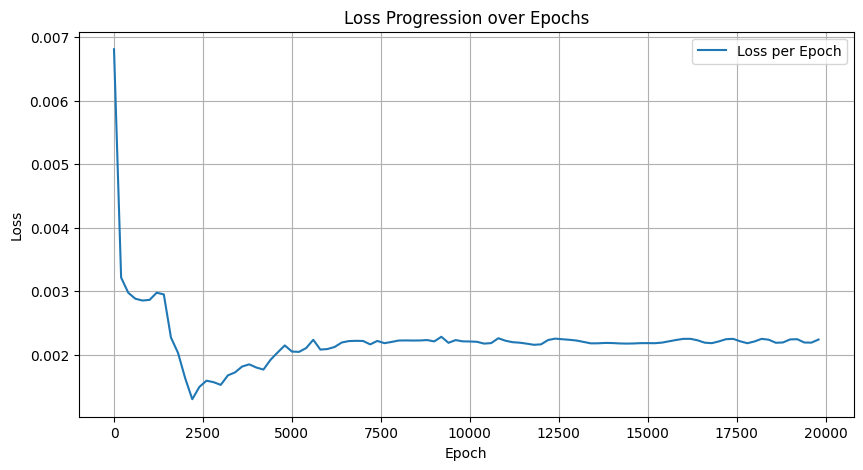

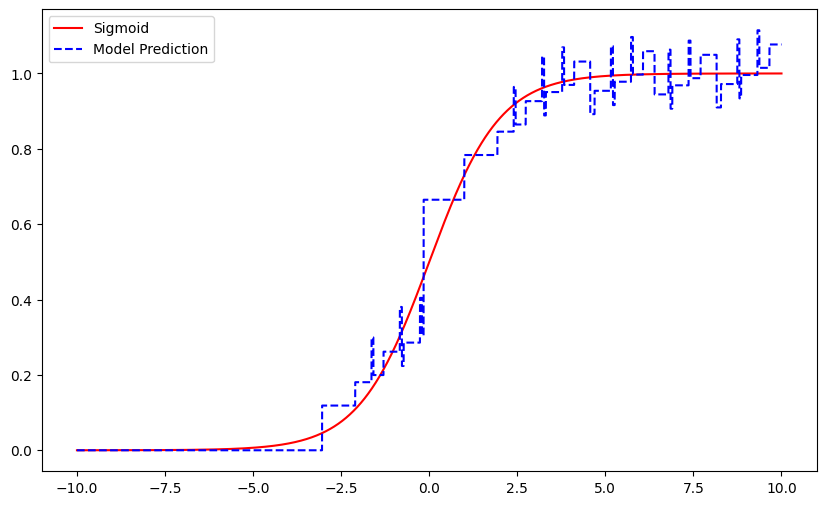

In [5]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-10, 10, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = sigmoid(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = sigmoid(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Sigmoid', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
# plt.xlabel('Input x')
# plt.ylabel('Output y')
plt.legend()

plt.show()

K=12

Epoch 1/20000, Loss: 0.00015756259381305426
Epoch 1001/20000, Loss: 0.00014784635277464986
Epoch 2001/20000, Loss: 0.00013402721378952265
Epoch 3001/20000, Loss: 0.00010042811481980607
Epoch 4001/20000, Loss: 7.956571789691225e-05
Epoch 5001/20000, Loss: 7.609582098666579e-05
Epoch 6001/20000, Loss: 5.305697050062008e-05
Epoch 7001/20000, Loss: 4.558590808301233e-05
Epoch 8001/20000, Loss: 4.25981888838578e-05
Epoch 9001/20000, Loss: 4.3914194975513965e-05
Epoch 10001/20000, Loss: 4.481267387745902e-05
Epoch 11001/20000, Loss: 4.300444561522454e-05
Epoch 12001/20000, Loss: 5.1414896006463096e-05
Epoch 13001/20000, Loss: 4.9455698899691924e-05
Epoch 14001/20000, Loss: 4.790859384229407e-05
Epoch 15001/20000, Loss: 3.66567364835646e-05
Epoch 16001/20000, Loss: 3.090995232923888e-05
Epoch 17001/20000, Loss: 2.9263726901263e-05
Epoch 18001/20000, Loss: 2.9423797968775034e-05
Epoch 19001/20000, Loss: 2.9688275390071794e-05
Loss values: [0.00015756259381305426, 0.00016733177471905947, 0.0001

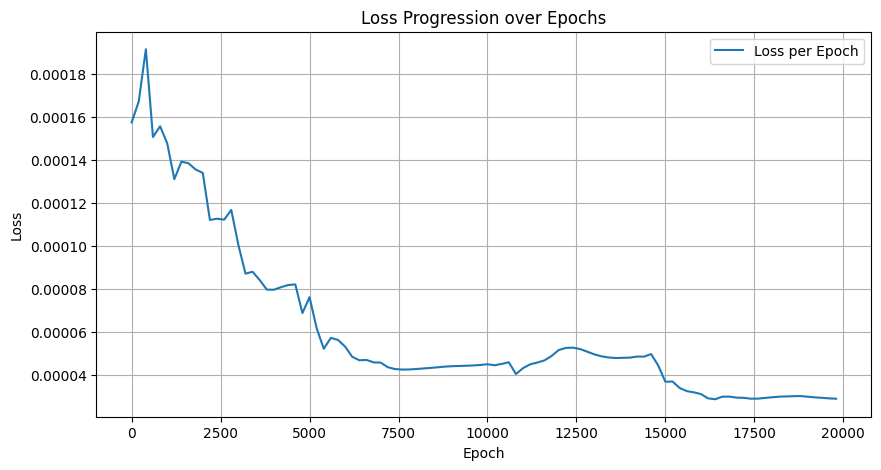

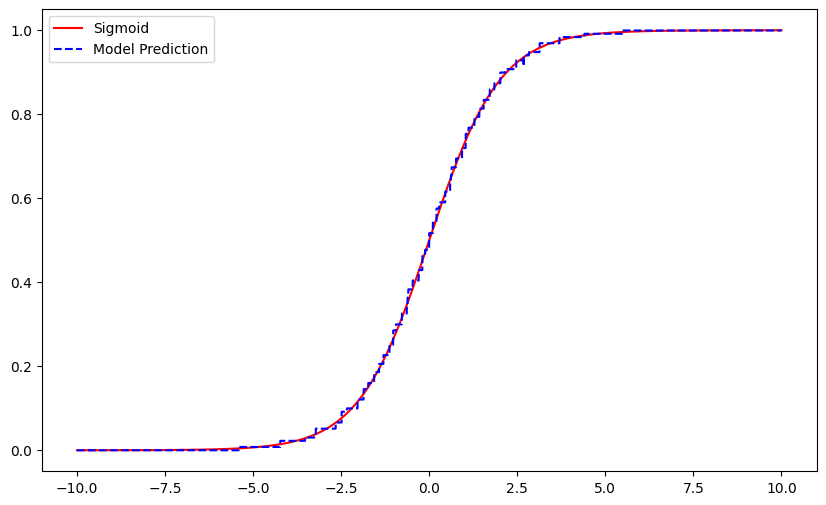

In [6]:
# Instantiate model and initial setup
num_params = 12  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-10, 10, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = sigmoid(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = sigmoid(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Sigmoid', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
# plt.xlabel('Input x')
# plt.ylabel('Output y')
plt.legend()

plt.show()

K=16

Epoch 1/20000, Loss: 0.06945733726024628
Epoch 1001/20000, Loss: 0.00047051048022694886
Epoch 2001/20000, Loss: 0.0003301182296127081
Epoch 3001/20000, Loss: 0.0003244119288865477
Epoch 4001/20000, Loss: 0.0003299665404483676
Epoch 5001/20000, Loss: 0.00033215698204003274
Epoch 6001/20000, Loss: 0.0003523353661876172
Epoch 7001/20000, Loss: 0.00039948616176843643
Epoch 8001/20000, Loss: 0.00043142432696186006
Epoch 9001/20000, Loss: 0.00046529166866093874
Epoch 10001/20000, Loss: 0.0004952911986038089
Epoch 11001/20000, Loss: 0.0005177394486963749
Epoch 12001/20000, Loss: 0.0005212848191149533
Epoch 13001/20000, Loss: 0.0005244474159553647
Epoch 14001/20000, Loss: 0.0005222443724051118
Epoch 15001/20000, Loss: 0.0005218398873694241
Epoch 16001/20000, Loss: 0.0005239088786765933
Epoch 17001/20000, Loss: 0.0005252708215266466
Epoch 18001/20000, Loss: 0.0005266360240057111
Epoch 19001/20000, Loss: 0.0005271982518024743
Loss values: [0.06945733726024628, 0.008283928036689758, 0.00138077791

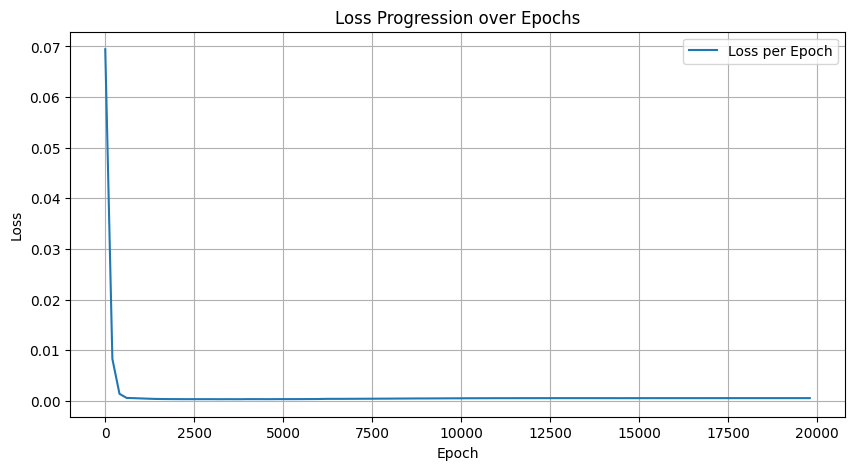

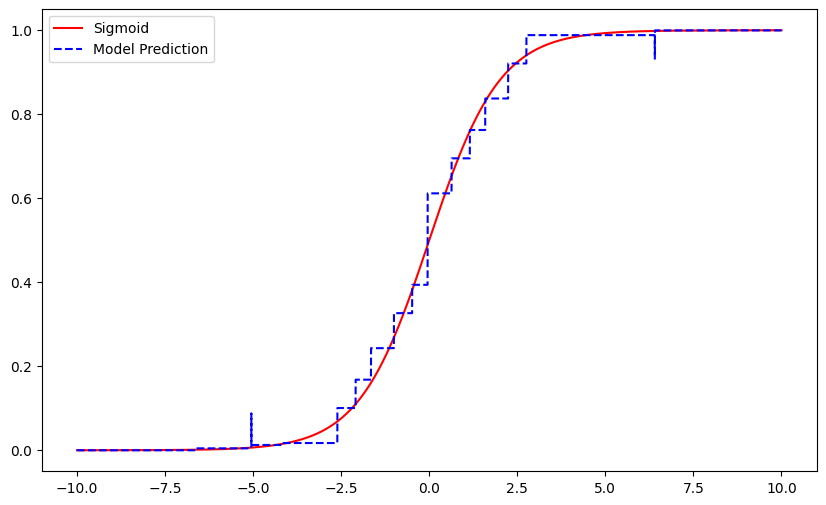

In [7]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-10, 10, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = sigmoid(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Plot loss values
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 200), loss_values, label='Loss per Epoch')
plt.title('Loss Progression over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = sigmoid(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='Sigmoid', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
# plt.xlabel('Input x')
# plt.ylabel('Output y')
plt.legend()

plt.show()